<a href="https://colab.research.google.com/github/nikonikoni123/buscador_info_nacional/blob/main/Buscador_info_nacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nota: implementar funcionalidad de r1_1.5B para mejor resultado.

## Proyecto Nikou: Mi Asistente Digital para Conectar al Ciudadano y el Estado en Colombia

# Introducción

Desde que empecé a interesarme por la transformación digital, he notado lo difícil que resulta encontrar información en los distintos portales .gov.co. a menudo, la navegación se vuelve confusa y frustrante. Por eso, decidí crear Nikou, un chatbot que pueda acompañarte tanto en WhatsApp como directamente en las páginas .gov.co, para facilitar el acceso a la información pública de manera rápida y sencilla.
Lastimosamente esta primera versión no puede ser desplegada en WhatsApp por falta de recursos económicos, siendo esta primera versión un prototipo técnico que sueño con verlo implementado en la realidad.

# Objetivos


1. Bajo la premisa de una búsqueda Eficiente de Información: En esta primera etapa, Nikou actúa como un buscador inteligente, redirigiéndote al sitio o documento (PDF) correcto según tu consulta, ahorrando tiempo y complicaciones.
2. Simplificación de la Experiencia Digital: Transforma la forma en que interactuar con la información, evitando textos largos y técnicos, ofreciendo una respuesta clara, fácil de entender.
3. Fundamento para el Futuro: Este proyecto es solo el comienzo; la visión es que Nikou evolucione y se integre a todas las tecnologías nacionales creadas hasta convertirse en una Inteligencia Artificial General (AGI) pública no dependiente de servicios terceros para una protección de datos eficiente, capaz de gestionar tareas complejas y adaptarse a las necesidades de cada ciudadano.

# Descripción de la Herramienta

Nikou es una propuesta integradora que busca simplificar la vida digital, facilitando el acceso a información. La idea es que funcione como tu asistente personal, en diversas plataformas de acceso limitado para acompañar a los usuarios en cada paso desde las regiones:


- Redirección Inteligente: Cuando cuentas lo que necesitas, Nikou actúa de inmediato para identificar y dirigirte a la página o documento oficial correcto, evitando que tengas que buscar manualmente.
- Accesibilidad Universal: Con su presencia en WhatsApp, cualquier persona, sin importar su nivel de familiaridad con la tecnología, puede obtener la información estatal de forma rápida y eficiente.

- Visión a Futuro: Evolución hacia una AGI Pública:


La meta es transformar y actualizar la gestión pública, convirtiendo a Nikou en un entorno de Inteligencia Artificial General (AGI) que gestione múltiples procesos estatales de forma autónoma y eficiente, adaptando a las necesidades del ciudadano y funcionarios especializados.



# Conclusión

El proyecto Nikou nace de mi convicción de que el acceso a la información correcta no tiene por qué ser complicada. Con este asistente digital, quiero acercar a la ciudadanía y las diferentes herramientas tecnológicas públicas de manera directa y sencilla, ya sea a través de WhatsApp o en las páginas .gov.co. Hoy, Nikou es tu buscador inteligente, pero mi visión es que se convierta en un compañero digital completo, transformando la experiencia de interacción. Estoy convencido de que, con este proyecto, la función pública se volverá más cercana, eficiente e inclusiva para todos.



## NOTAS ADICIONALES DE AUTOR:
 esta es una versión beta realizada en mi tiempo libre desde la clínica de la sabana, continuando su desarrollo apasionadamente desde casa, logrando implementar servicios de r1 7B de manera local e independiente, generando un control privado de información.



En un inicio fue planeado como complemento a un modelo bert que he ido realizando por más de 2 años que busca optimizar la búsqueda de procesos judiciales.
El modelo bert busca entender la normativa aplicable en cada consulta para tener una comprensión legal que pueda facilitar el acceso a la documentación (este modelo se encuentra en entrenamiento) sin embargo el proyecto fue creciendo hasta obtener vida propia, siendo una alternativa amigable y necesaria.

# Como funciona:
- es un sistema simple, por medio de search realiza una búsqueda inicial limitando a solo páginas de dominio.gov.co.
- Extrae la información por medio de scraping plano, elimina las etiquetas html encontradas.
- Cita el link de la página web.
- Resume y comprime la información para ser más accesible al usuario.
- Si la información no es encontrada, verifica documentos pdf de dominio .gov.co extrae la información y verifica si el documento tiene similitud con la consulta.


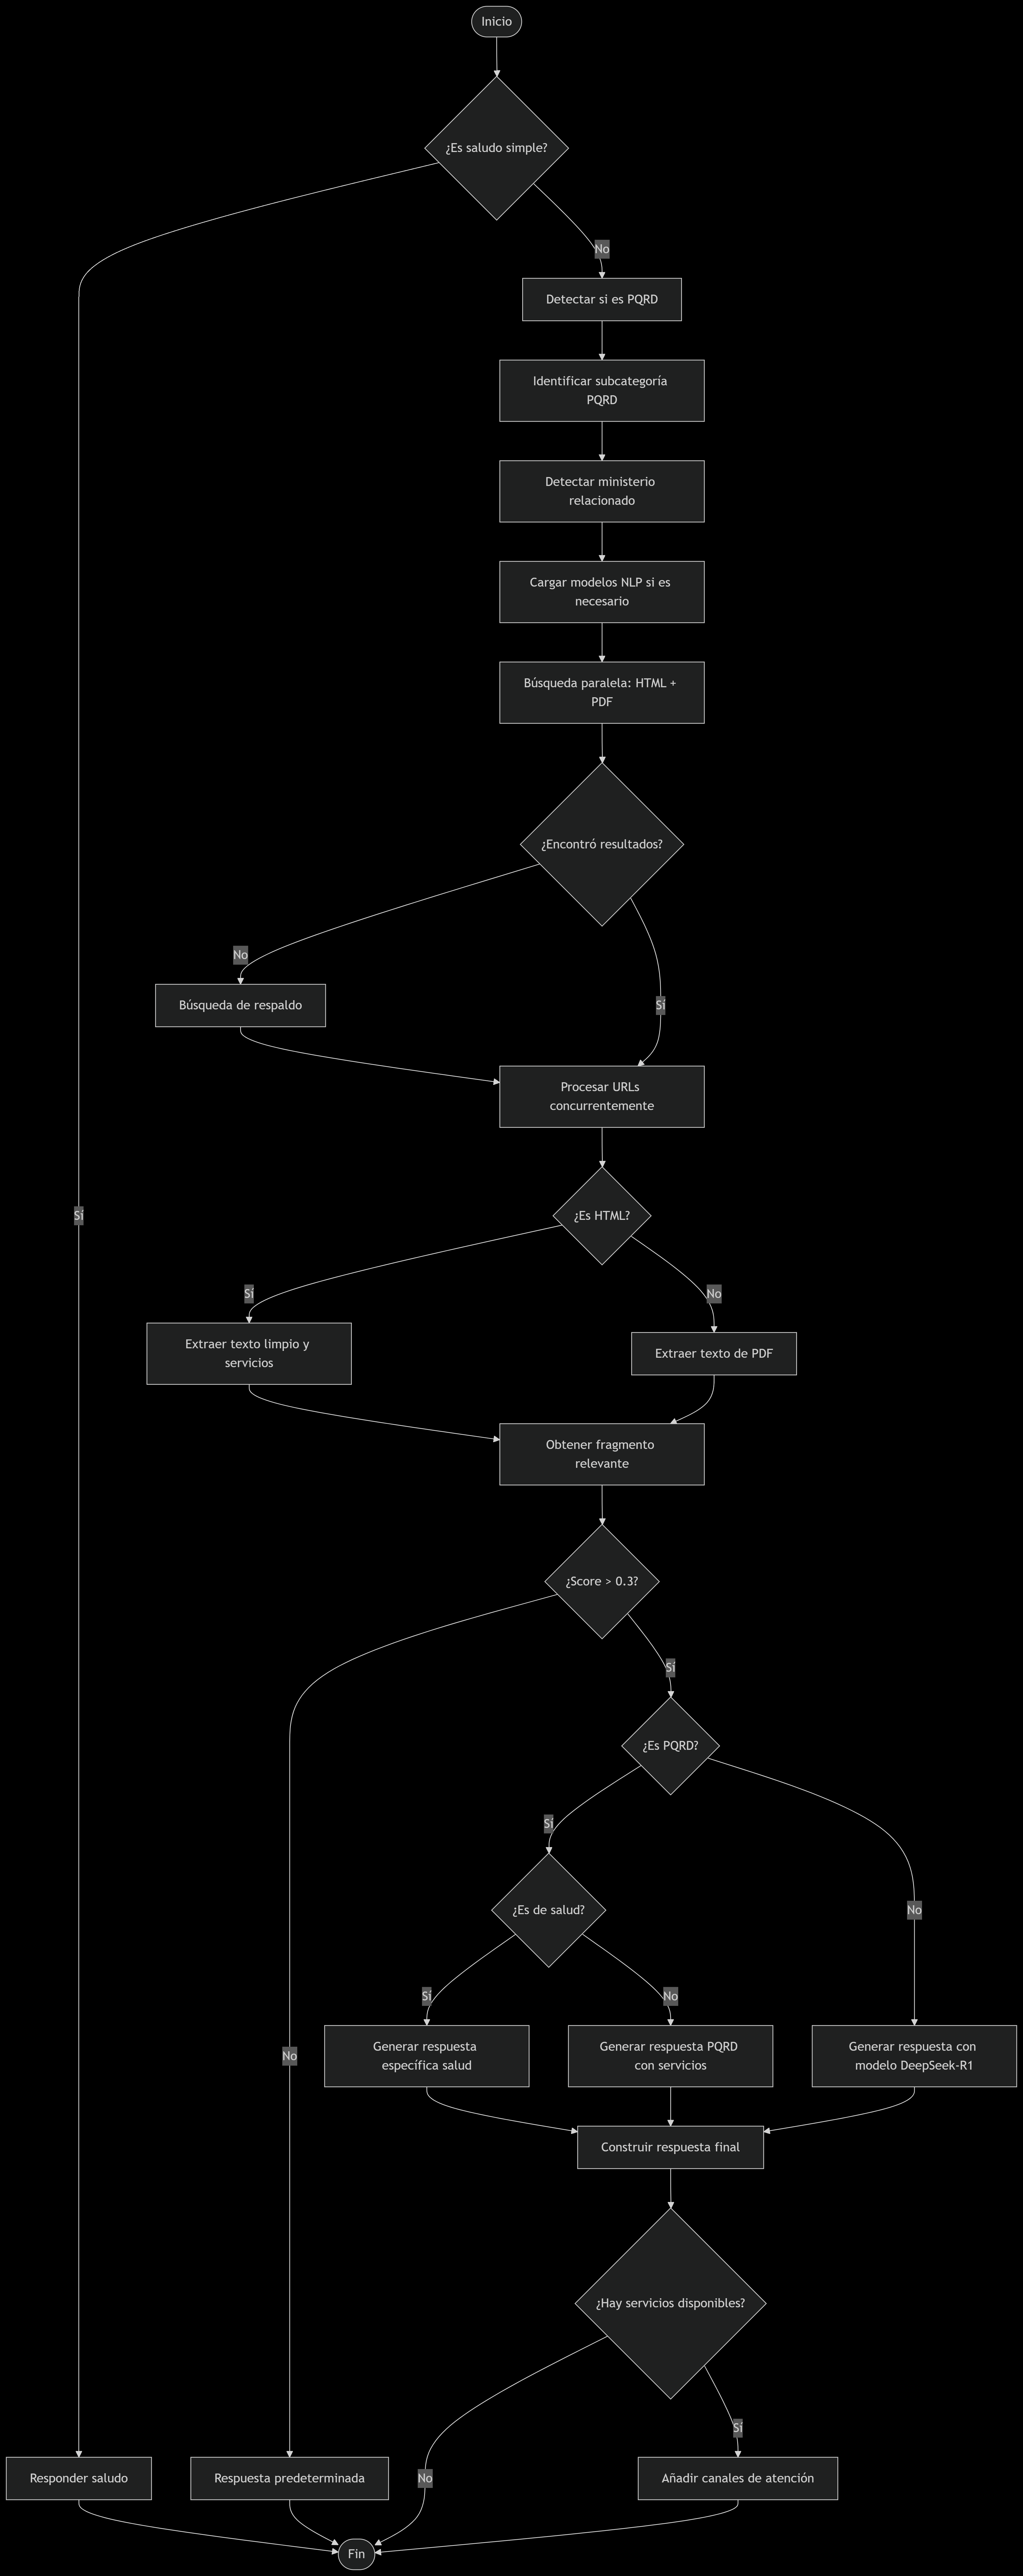

- debido a compromisos de salud, realice modificaciones de código en compañía de chatgpt modelo O3.


## Nota:
# Se debe ejecutar en un entorno GPU T4 o superior
Disculpa por errores de ortografía este código lo estoy desarrollando hospitalizado desde la clínica universidad de la sabana, esto dificulta el desarrollo.




# Autor:
Nicolas Andres Rodriguez Alarcon.

## CODIGO

In [ ]:
!pip install transformers huggingface_hub

from huggingface_hub import notebook_login
from google.colab import userdata

# Log in to Hugging Face Hub
# This will use the HF_TOKEN secret you added earlier
notebook_login()

# Alternatively, if you prefer not to use notebook_login, you can set the token directly
# from huggingface_hub import HfApi
# api = HfApi()
# hf_token = userdata.get('HF_TOKEN')
# api.set_access_token(hf_token)
# print("Hugging Face token set.")

"""
Instala los tokens de search y engine de google por terminal
"""

In [ ]:
import subprocess
import sys

# Lista de paquetes a instalar
packages = [
    "spacy",
    "transformers",
    "torch",
    "sentence-transformers",
    "beautifulsoup4",
    "lxml",
    "google-api-python-client",
    "pdfminer.six",
    "PyPDF2",
    "PyMuPDF",
    "selenium",
    "gradio"
]

# Instalar los paquetes
for package in packages:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    except subprocess.CalledProcessError as e:
        print(f"Error instalando {package}: {e}")

try:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "es_core_news_lg"])
except subprocess.CalledProcessError as e:
    print(f"Error descargando el modelo de spacy: {e}")

In [ ]:
import spacy
import requests
import re
import fitz
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer, util
from bs4 import BeautifulSoup
from googlesearch import search
import html
import concurrent.futures
from pdfminer.high_level import extract_text
import pdfminer
import PyPDF2
from io import BytesIO
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import gradio as gr
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
import requests
import concurrent.futures
import urllib.parse
from googleapiclient.discovery import build
import os

# Suprimir advertencias de certificados
requests.packages.urllib3.disable_warnings()

# Cargar solo modelos esenciales
nlp = spacy.load("es_core_news_lg")
nlp.max_length = 1000000

API_KEY = os.environ.get("GOOGLE_API_KEY")
SEARCH_ENGINE_ID = os.environ.get("CSE_ID")

model_r1 = None
tokenizer_r1 = None
model_embed = None

# Modelos cargados bajo demanda
def load_models():
  global tokenizer_r1, model_r1, model_embed
  model_r1_name = "google/gemma-3-4b-it"
  if model_r1 is None:
    model_r1 = AutoModelForCausalLM.from_pretrained(
      model_r1_name,
      device_map="auto",
      torch_dtype=torch.float16,
      low_cpu_mem_usage=True
    )
    model_r1.eval()
  if tokenizer_r1 is None:
    tokenizer_r1 = AutoTokenizer.from_pretrained(model_r1_name)
    tokenizer_r1.pad_token = tokenizer_r1.eos_token
  if model_embed is None:
    model_embed = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Lista de variables
- MINISTRY_DOMAINS
- Keywords
- saludos

ACTUALIZAR

In [ ]:
# Mapeo de palabras clave a dominios de ministerios
MINISTRY_DOMAINS = {
    "minjusticia": "minjusticia.gov.co", # Ministerio de justicia
    "mininterior": "mininterior.gov.co", # Ministerio del interior
    "datosabiertos": "datos.gov.co", # portal datos abiertos
    "minhacienda": "minhacienda.gov.co", # Ministerio de Hacienda
    "mindefensa": "mindefensa.gov.co", # Ministerio de defensa
    "minagricultura": "minagricultura.gov.co", # Ministerio de cultura
    "mintrabajo": "mintrabajo.gov.co", # Ministerio de trabajo
    "minenergia": "minenergia.gov.co", # Ministerio de minas y energia
    "mincit": "mincit.gov.co",  # Ministerio de Comercio, Industria y Turismo
    "minambiente": "minambiente.gov.co", # Ministerio de ambiente
    "minvivienda": "minvivienda.gov.co", # Ministerio de vivienda
    "mintic": "mintic.gov.co", # Ministerio TIC
    "minsalud": "minsalud.gov.co", # Ministerio de salud
    "procuraduria": "procuraduria.gov.co",  # Procuraduría General de la Nación
    "gobierno": "gov.co", # Dominio general para trámites comunes
    "cancilleria": "cancilleria.gov.co" # Dominio general cancilleria
}

# Palabras clave para cada ministerio
keywords = {
  "minjusticia": ["justicia", "penal", "criminal", "juez", "fiscal", "delito", "prisión"],
  "mininterior": ["interior", "municipio", "departamento", "gobernacion", "alcaldía", "registraduría"],
  "datosabiertos": ["datos abiertos", "open data", "estadística", "censo", "indicador"],
  "minhacienda": ["hacienda", "impuestos", "renta", "presupuesto", "tributario", "arancel", "tarifa"],
  "mindefensa": ["defensa", "militar", "ejercito", "armada", "policía", "seguridad"],
  "minagricultura": ["agricultura", "campo", "cultivos", "ganaderia", "agrario", "rural"],
  "mintrabajo": ["trabajo", "empleo", "desempleo", "laboral", "pension", "cesantías"],
  "minenergia": ["energia", "petroleo", "gas", "electricidad", "minería", "combustible"],
  "mincit": ["industria", "turismo", "comercio", "exportacion", "importación", "emprendimiento"],
  "minambiente": ["ambiente", "ecologia", "contaminacion", "biodiversidad", "fauna", "flora"],
  "minvivienda": ["vivienda", "construccion", "vivienda social", "urbano", "catastro"],
  "mintic": ["tic", "tecnologia", "internet", "computadores", "digital", "software"],
  "minsalud": ["salud", "pqrd", "petición", "queja", "reclamo", "denuncia",
    "hospital", "medicina","medicamento","medicamentos", "enfermedad", "paciente", "medicamento",
    "salud pública", "atención médica", "servicio de salud",
    "eps", "ips", "arl", "aseguradora", "prestador de servicios de salud",
    "clínica", "centro de salud", "entidad promotora de salud",
    "institución prestadora de salud", "sisben", "plan obligatorio de salud",
    "autorización", "glosa", "facturación"],
  "tramites": ["pqrd", "pqrsd", "pqrdsf", "petición", "queja", "reclamo", "denuncia", "sugerencia", "felicitaciones", "pqr",
               "requerimiento","protesta", "inconformidad", "formulario", "trámite", "servicio"],
  "cancilleria":["pasaportes","visado","visa","pasaporte","cancilleria","canciller","paises","pais","embajada","embajadas"]

}

saludos = ["hola", "buenos días", "buenas tardes", "buenas noches",
            "cómo estás", "qué tal", "saludos","como estas"]

#________________________________________________________________________________________________________________________
# Identifica si es PQRD__________________________________________________________________________________________________
# Mapeo de subcategorías de PQRD
PQRD_CATEGORIES = {
    "petición": [
        "peticion", "solicitud", "requerimiento", "protección", "derechos",
        "intereses", "información", "documento"
    ],
    "queja": [
        "queja", "protesta", "censura", "descontento", "inconformidad",
        "conducta irregular", "servidor público", "funcionario"
    ],
    "reclamo": [
        "reclamo", "prestación indebida", "servicio deficiente",
        "falta de atención", "demora", "incumplimiento"
    ],
    "denuncia": [
        "denuncia", "hechos irregulares", "irregularidad", "corrupción",
        "conducta indebida", "delito", "ilícito"
    ],
    "sugerencia": [
        "sugerencia", "propuesta", "mejora", "idea", "recomendación",
        "innovación"
    ],
    "felicitaciones": [
        "felicitaciones", "reconocimiento", "gratitud", "elogio",
        "satisfacción", "agradecimiento"
    ]
}

# definiciones de pqrd
definiciones = {
  "petición": "Requerimiento que pretende la atención o protección de intereses o derechos de carácter general.",
  "queja": "Manifestación de protesta, censura, descontento o inconformidad con conducta irregular de servidores públicos o contratistas.",
  "reclamo": "Manifestación de inconformidad por la prestación indebida de un servicio o falta de atención de una solicitud.",
  "denuncia": "Relato de hechos irregulares para conocimiento de las autoridades.",
  "sugerencia": "Presentación de una idea o propuesta para mejorar el servicio o la gestión.",
  "felicitaciones": "Expresión de satisfacción, reconocimiento, gratitud o elogio por la prestación de un servicio.",
  "general": "Mecanismo para presentar Peticiones, Quejas, Reclamos, Denuncias, Sugerencias y Felicitaciones."
}
# instrucciones de presentacion pqrd
instrucciones = {
  "petición": "Para presentar una petición, completa el formulario con tus datos personales y la descripción detallada de tu solicitud.",
  "queja": "Para presentar una queja, proporciona información específica sobre el servidor público o contratista y los hechos que consideras irregulares.",
  "reclamo": "Para presentar un reclamo, incluye referencia a la solicitud o servicio previo que no fue atendido adecuadamente.",
  "denuncia": "Para presentar una denuncia, describe con el mayor detalle posible los hechos irregulares que deseas reportar.",
  "sugerencia": "Para presentar una sugerencia, describe tu propuesta de mejora de manera clara y específica.",
  "felicitaciones": "Para presentar felicitaciones, identifica al servidor público o área que deseas reconocer y los motivos de tu satisfacción.",
  "general": "Selecciona el tipo de PQRD que deseas presentar y completa el formulario correspondiente."
}
# terminos asociados a salud
servicios_salud = ["atención médica", "cita médica", "medicamento", "tratamiento", "urgencias"]
terminos_salud = ["eps", "ips", "aseguradora", "prestador de salud", "clínica", "hospital",
  "salud", "médico", "medicamento", "paciente", "urgencias", "cita médica",
  "autorización", "glosa", "facturación", "pos", "plan obligatorio de salud"
]


# lista de Funciones:
- ensure_models_loaded
- memorize
- extract_clean_text
- detect_ministry
- simple_greeting
- parallel_search
- robust_session
- extract_text_pdf
- extract_text_pdf_fallback
- get_relevant_fragment
- fetch_url_content
- chatbot_response

ACTUALIZAR

In [ ]:
def robust_session():
    """Crea una sesión de requests con reintentos para mayor estabilidad."""
    session = requests.Session()
    retry_strategy = Retry(total=3, status_forcelist=[429, 500, 502, 503, 504], backoff_factor=1)
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    return session

def detect_attention_services(soup: BeautifulSoup, base_url: str) -> dict:
    """Detecta canales de atención (chats, formularios, etc.) en el HTML."""
    servicios = {'chatbots': [], 'formularios_contacto': [], 'lineas_telefonicas': [], 'correos': [], 'preguntas_frecuentes': []}
    # (Lógica completa de detección de servicios)
    servicios['formularios_contacto'] = [urllib.parse.urljoin(base_url, form.get('action')) for form in soup.select('form[action*="contact"], form[id*="contact"]') if form.get('action')]
    phone_pattern = re.compile(r'(\+\d{1,4}[-.\s]?)?(\d{2,4}[-.\s]?){3,4}\d{2,4}')
    servicios['lineas_telefonicas'] = list(set(p[0] for p in phone_pattern.findall(soup.get_text()) if len(p[0]) > 7))
    email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
    servicios['correos'] = list(set(email_pattern.findall(soup.get_text())))[:3]
    return servicios

def extract_clean_text(html_content: str, url: str) -> tuple:
    """Extrae texto limpio de HTML y detecta servicios de atención."""
    soup = BeautifulSoup(html_content, 'lxml')
    for tag in soup(['script', 'style', 'nav', 'footer', 'header', 'aside', 'form']):
        tag.decompose()
    main_content = soup.find('main') or soup.find('article') or soup.find('body')
    text = main_content.get_text(separator='.', strip=True) if main_content else ""
    servicios = detect_attention_services(soup, url)
    return text, servicios

def fetch_content(url: str) -> tuple:
    """Descarga y extrae contenido de una URL, sea HTML o PDF."""
    try:
        session = robust_session()
        response = session.get(url, timeout=12, headers={'User-Agent': 'Mozilla/5.0'}, verify=False)
        response.raise_for_status()

        if 'application/pdf' in response.headers.get('Content-Type', ''):
            with BytesIO(response.content) as pdf_file:
                reader = PyPDF2.PdfReader(pdf_file)
                text = "\n".join(page.extract_text() for page in reader.pages if page.extract_text())
            return text, {} # Los PDFs no tienen servicios interactivos
        else:
            return extract_clean_text(response.text, url)
    except Exception:
        return "", {}

def detect_ministry(query: str) -> str:
    """Determina el dominio del gobierno más relevante."""
    query_lower = query.lower()
    if any(k in query_lower for k in terminos_salud): return MINISTRY_DOMAINS["minsalud"]
    if "procuraduría" in query_lower or "denuncia disciplinaria" in query_lower: return MINISTRY_DOMAINS["procuraduria"]
    for ministry, kws in keywords.items():
        if any(kw in query_lower for kw in kws):
            return MINISTRY_DOMAINS[ministry]
    return MINISTRY_DOMAINS["gobierno"]

def parallel_search(query: str, num_results: int = 3, is_pdf: bool = False):
    """Realiza la búsqueda con la API de Google."""
    if CUSTOM_SEARCH_API_KEY == "TU_API_KEY_AQUI":
        # print("ADVERTENCIA: Usando búsqueda simulada.")
        return [f"https://simulado.gov.co/{query.replace(' ', '_')}.html"]
    try:
        dominio = detect_ministry(query)
        q = f'"{query}" site:{dominio}' + (' filetype:pdf' if is_pdf else '')
        service = build("customsearch", "v1", developerKey=CUSTOM_SEARCH_API_KEY)
        res = service.cse().list(q=q, cx=CUSTOM_SEARCH_ENGINE_ID, num=num_results).execute()
        return [item['link'] for item in res.get('items', [])]
    except Exception as e:
        print(f"Error en búsqueda API: {e}")
        return []

def get_relevant_fragment(text: str, query: str) -> tuple:
    """Encuentra el fragmento más relevante de un texto usando IA."""
    if not text: return "", 0.0
    sents = [s.strip() for s in text.split('.') if len(s.strip()) > 40]
    if not sents: return text[:800], 0.4
    load_models()
    query_embedding = model_embed.encode(query, convert_to_tensor=True)
    sent_embeddings = model_embed.encode(sents, convert_to_tensor=True)
    cos_scores = util.pytorch_cos_sim(query_embedding, sent_embeddings)[0]
    top_idx = torch.argmax(cos_scores).item()
    return sents[top_idx], cos_scores[top_idx].item()

def detect_subcategory_pqrd(query: str) -> str:
    """Detecta el tipo específico de PQRD."""
    query_lower = query.lower()
    for category, kws in PQRD_CATEGORIES.items():
        if any(kw in query_lower for kw in kws):
            return category
    return "general"

def response_pqrd(best_url: str, subcategoria: str, servicios: dict) -> str:
    """Genera una respuesta estructurada y específica para consultas PQRD."""
    respuesta = (f"**Fuente:** {best_url}\n\n"
                 f"**Tipo de Trámite:** PQRD ({subcategoria.capitalize()})\n"
                 f"**Definición:** {definiciones.get(subcategoria, '')}\n\n"
                 f"**Procedimiento General:** {instrucciones.get(subcategoria, '')}")
    if servicios and any(servicios.values()):
        respuesta += "\n\n**Canales de Atención Encontrados:**"
        if servicios.get('formularios_contacto'):
            respuesta += f"\n- **Formulario en línea:** {servicios['formularios_contacto'][0]}"
        if servicios.get('lineas_telefonicas'):
            respuesta += f"\n- **Línea telefónica:** {servicios['lineas_telefonicas'][0]}"
        if servicios.get('correos'):
            respuesta += f"\n- **Correo electrónico:** {servicios['correos'][0]}"
    return respuesta

In [ ]:
def chatbot_response(consulta: str) -> str:
    """Función principal que orquesta el flujo de la conversación."""
    # Flujo 1: Saludo simple
    if any(s in consulta.lower() for s in saludos):
        return "¡Hola! Soy tu asistente virtual para trámites y servicios del gobierno colombiano. ¿En qué puedo ayudarte hoy?"

    print(f"Procesando consulta: '{consulta}'")
    load_models()

    # Flujo 2: Búsqueda paralela de HTML y PDF
    print("Buscando en fuentes oficiales...")
    with concurrent.futures.ThreadPoolExecutor() as executor:
        html_urls = executor.submit(parallel_search, consulta, 3, is_pdf=False).result()
        pdf_urls = executor.submit(parallel_search, consulta, 2, is_pdf=True).result()
    all_urls = list(set(html_urls + pdf_urls))

    if not all_urls:
        return "Lo siento, no pude encontrar información en sitios oficiales para tu consulta."

    # Flujo 3: Procesamiento concurrente de URLs
    print(f"Se encontraron {len(all_urls)} URLs. Extrayendo y analizando contenido...")
    best_fragment, best_score, best_url, best_servicios = "", 0.0, "", {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(all_urls)) as executor:
        future_to_url = {executor.submit(fetch_content, url): url for url in all_urls}
        for future in concurrent.futures.as_completed(future_to_url):
            url = future_to_url[future]
            content, servicios = future.result()
            if content:
                fragment, score = get_relevant_fragment(content)
                if score > best_score:
                    best_fragment, best_score, best_url, best_servicios = fragment, score, url, servicios

    # Flujo 4: Generación de respuesta basada en el mejor contenido
    if best_score < 0.35: # Umbral de confianza
        return f"Encontré información, pero no estoy seguro de que responda tu pregunta. Puedes revisar la fuente más relevante: {best_url}" if best_url else "No pude encontrar una respuesta clara."

    # Flujo 5: Lógica de decisión para tipo de respuesta
    is_pqrd = any(kw in consulta.lower() for kw in keywords["tramites"])
    is_health = any(kw in consulta.lower() for kw in terminos_salud)

    # Caso A: PQRD de Salud
    if is_pqrd and is_health:
        return response_pqrd(best_url, "Salud", best_servicios)

    # Caso B: Otro tipo de PQRD
    if is_pqrd:
        subcategoria = detect_subcategory_pqrd(consulta)
        return response_pqrd(best_url, subcategoria, best_servicios)

    # Caso C: Consulta General (usa el modelo Gemma)
    print("Generando respuesta con el modelo de IA...")
    prompt = f'Basado exclusivamente en el siguiente contexto, responde la pregunta de forma clara y concisa.\n\nContexto: "{best_fragment}"\n\nPregunta: "{consulta}"\n\nRespuesta:'
    inputs = tokenizer_r1(prompt, return_tensors="pt", max_length=1024, truncation=True).to(model_r1.device)

    with torch.no_grad():
        outputs = model_r1.generate(**inputs, max_new_tokens=250, temperature=0.7)

    respuesta_modelo = tokenizer_r1.decode(outputs[0], skip_special_tokens=True).split("Respuesta:")[-1].strip()

    respuesta_final = f"**Fuente:** {best_url}\n\n**Respuesta:** {respuesta_modelo}"
    # Añadir canales de atención si se encontraron
    if best_servicios and any(best_servicios.values()):
        respuesta_final += "\n\n**Canales de Atención Relacionados en la Página:**"
        if best_servicios.get('formularios_contacto'):
            respuesta_final += f"\n- **Formulario en línea:** {best_servicios['formularios_contacto'][0]}"
        if best_servicios.get('lineas_telefonicas'):
            respuesta_final += f"\n- **Línea telefónica:** {best_servicios['lineas_telefonicas'][0]}"

    return respuesta_final

## Testeo por consola:
Esta fracción de código verifica la precisión del modelo.

# Correcciones:
Corregir fallos de respuesta en el modelo ya que cita el documento equivocado.
- Cambiar buscador inteligente para desligar el modelo de los servicios de google search

In [ ]:
# Ejemplo de interacción en consola
if __name__ == "__main__":
    print("El sistema está listo. Ingresa tu consulta o escribe 'salir' para terminar.")

    while True:
        consulta_usuario = input("\nTú: ")
        if consulta_usuario.lower() in ['salir', 'exit', 'quit']:
            print("Asistente: ¡Hasta luego!")
            break

        if not consulta_usuario.strip():
            continue

        respuesta_bot = chatbot_response(consulta_usuario)
        print(f"\nAsistente:\n{respuesta_bot}")

El sistema está listo. Ingresa tu consulta o escribe 'salir' para terminar.

Tú: hola como puedo solicitar información del ministerio de ciencias

Asistente:
¡Hola! Soy tu asistente virtual para trámites y servicios del gobierno colombiano. ¿En qué puedo ayudarte hoy?

Tú: como puedo solicitar información del ministerio de ciencias
Procesando consulta: 'como puedo solicitar información del ministerio de ciencias'


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/google/gemma-3-4b-it.
401 Client Error. (Request ID: Root=1-68fa3db3-40771a7957c0b9fb47da5bd3;90545021-753c-47dd-82ca-c860749d4b28)

Cannot access gated repo for url https://huggingface.co/google/gemma-3-4b-it/resolve/main/config.json.
Access to model google/gemma-3-4b-it is restricted. You must have access to it and be authenticated to access it. Please log in.

## Ejemplo interfaz grafica

In [ ]:
# Función que procesa cada mensaje del usuario
def chat_fn(message, history):
    # Puedes extender aquí la lógica para determinar si la consulta es nacional o regional.
    # Para el prototipo, asumiremos que se trata de una consulta nacional.
    respuesta = chatbot_response(message, "")
    return respuesta

# Construir la interfaz de chat usando Gradio Blocks y el componente Chatbot
demo = gr.ChatInterface(chat_fn, type="messages", autofocus=False)

demo.launch()

# Fases del proyecto: (Perfeccionar)
1. Generar un buscador de información publica, directo y confiable que realice las consultas de forma adecuada.
2. descentralizar la información.
3. integrar los servicios externos.gov.co que se encuentren habilitados


## CORRECCIONES PENDIENTES VERSION 1:

- Se debe mejorar el proceso de filtrado de información nacional y regional.

# Futuras versiones:
- Se debe generar un buscador no indexado que permita la no dependencia de los servicios de google, para ello existe la búsqueda de información vectorial o lang search.
- La interfaz gráfica desarrollada es solo un ejemplo la idea es desplegarlo en un servicio de WhatsApp o una interfaz gráfica más amigable con el usuario.
- Se debe optimizar el tiempo de respuesta de cada petición.
- se debe integrar a los otros servicios chatbots y aplicaciones ya disponibles en el sector público.


Referencias:
https://www1.funcionpublica.gov.co/documents/28587410/38139874/2021-03%2023_Politica_servicio_al_ciudadano_actualizada.pdf/a8f37301-0e89-d6da-9708-ce72772cde6f?t=1619450714666

https://www.dnp.gov.co/Prensa_/Noticias/Paginas/el-dnp-presenta-su-asistente-virtual-rebeca-una-herramienta-digital-para-dar-respuesta-a-la-ciudadania.aspx

https://www.webfindyou.com.co/blog/cuales-son-ventajas-chatbots-detalles-que-colombianos-deben-saber/

https://bogota.gov.co/en/node/170744

https://chatbotcolombia.com/participacion-ciudadana/chatbots-conversacionales-potenciando-la-participacion-ciudadana-en-instituciones-publicas/

https://www.dnp.gov.co/Prensa_/Noticias/Paginas/el-dnp-presenta-su-asistente-virtual-rebeca-una-herramienta-digital-para-dar-respuesta-a-la-ciudadania.aspx

https://langsearch.com/

https://huggingface.co/deepseek-ai/DeepSeek-R1-Distill-Qwen-7B

https://github.com/deepseek-ai/DeepSeek-R1/blob/main/LICENSE

## License

MIT License

Copyright (c) 2025 Nicolas Rodriguez



Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.